<a href="https://colab.research.google.com/github/J-Milando-10/STA-365-Homework/blob/main/STA365_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm

from google.colab import files
uploaded = files.upload() #this will prompt you to choose a file
import io
df = pd.read_csv(io.BytesIO(uploaded['team_stats_2003_2023.csv']))

Saving team_stats_2003_2023.csv to team_stats_2003_2023.csv


In [2]:
print(df)


     year                  team  wins  losses  win_loss_perc  points  \
0    2003  New England Patriots    14       2          0.875     348   
1    2003        Miami Dolphins    10       6          0.625     311   
2    2003         Buffalo Bills     6      10          0.375     243   
3    2003         New York Jets     6      10          0.375     283   
4    2003      Baltimore Ravens    10       6          0.625     391   
..    ...                   ...   ...     ...            ...     ...   
667  2023     Carolina Panthers     2      15          0.118     236   
668  2023   San Francisco 49ers    12       5          0.706     491   
669  2023      Los Angeles Rams    10       7          0.588     404   
670  2023      Seattle Seahawks     9       8          0.529     364   
671  2023     Arizona Cardinals     4      13          0.235     330   

     points_opp  points_diff   mov   g  ...  rush_td  rush_yds_per_att  \
0           238          110   6.9  16  ...        9         

<function matplotlib.pyplot.show(close=None, block=None)>

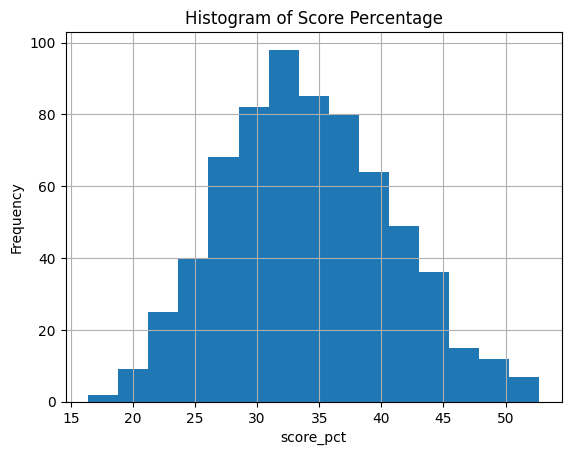

In [4]:
#Question 0,1

#hist of score_pct
df.hist('score_pct', bins = 15)
plt.xlabel("score_pct")
plt.ylabel('Frequency')
plt.title('Histogram of Score Percentage')
plt.show



In [27]:
#specify the prior parameters
theta_0,tau = 0,1;
alpha,beta = 2,1/2

np.random.seed(341688)

normal_gamma_model = pm.Model()
with normal_gamma_model:
  theta = pm.Normal('theta', mu = theta_0, sigma = tau)
  phi = pm.Gamma('phi', alpha = alpha, beta = beta)
  obs = pm.Normal('liklihood', mu = theta, sigma = 1/phi**0.5,
                  observed = df['score_pct'])


In [31]:
#HMC sampling
np.random.seed(341688)
with normal_gamma_model:
  idata_HMC = pm.sample()

In [32]:
#M-H sampling
np.random.seed(341688)
with normal_gamma_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=True,
                       tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))
/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 1.0002, 'phi': 1.0011} | MH Split-Rhats {'theta': 1.1197, 'phi': 1.0215}


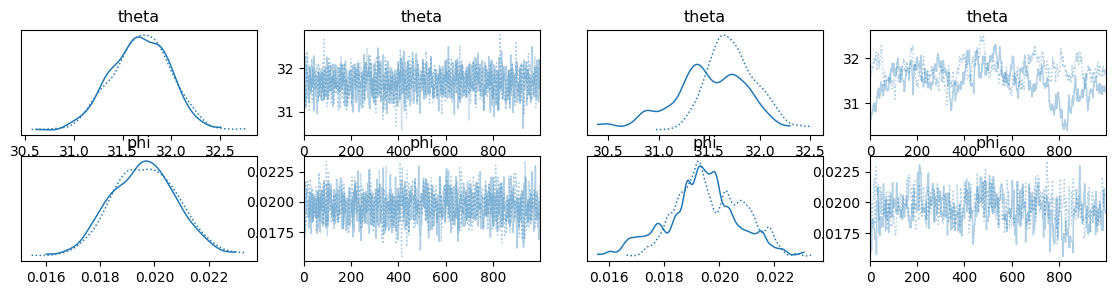

In [33]:
#Convergence diagnostics to make sure algorithm ran correctly and we converged
import arviz as az;
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]);
az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,
                          v in az.rhat(idata_HMC).items()}, end=' | ');
print('MH Split-Rhats',{k: np.round(v.values,4) for k,
                        v in az.rhat(idata_MH).items()})
#both runs look the same which is what we want especially for HMC,
#means we can get reliably reproducable results. less so for MH
#also can see that we are converging, stronger convergence in HMC than in MH

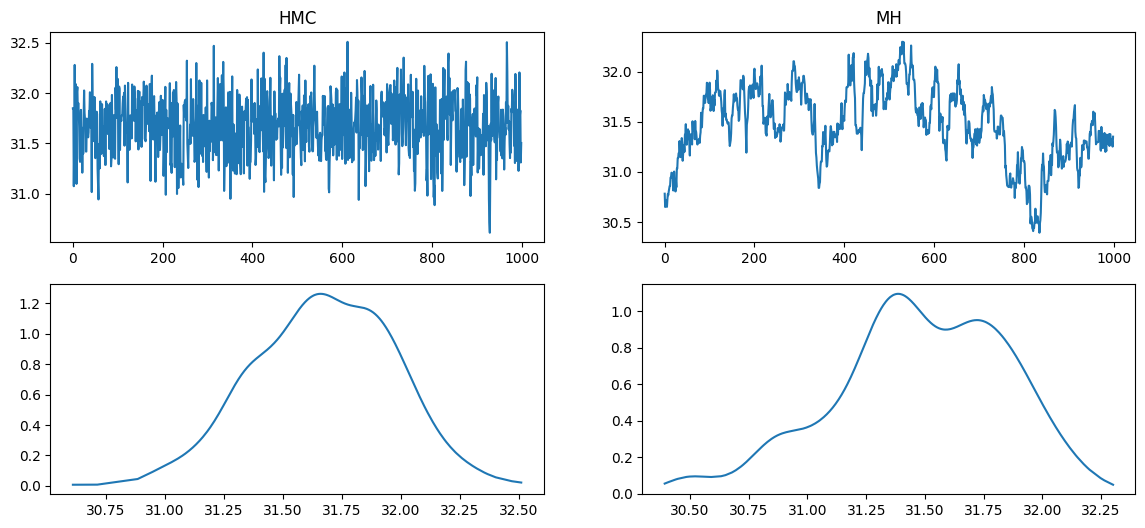

In [38]:
#Closer look at convergence diagnostics
from scipy.stats import gaussian_kde;
import matplotlib.pyplot as plt;
iterations = 100 # Gibbs Samples
theta_gibbs_posterior_mcmc_draws,phi_gibbs_posterior_mcmc_draws = np.zeros(iterations+1),np.zeros(iterations+1)
burn = 20

fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0,
                                              draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain);
ax[1,0].plot(mcmc_chain_sorted,
             gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0,
                                             draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain);
ax[1,1].plot(mcmc_chain_sorted,
             gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0,1].set_title("MH");

#again we see much stronger convergence in the HMC method, and a more normal
# pattern in distribbution than in MH

Autocorrelation for HMC (MCMC) chain 0.2756782282977817 
Autocorrelation for MH (MCMC) chain 0.7775071191495371 


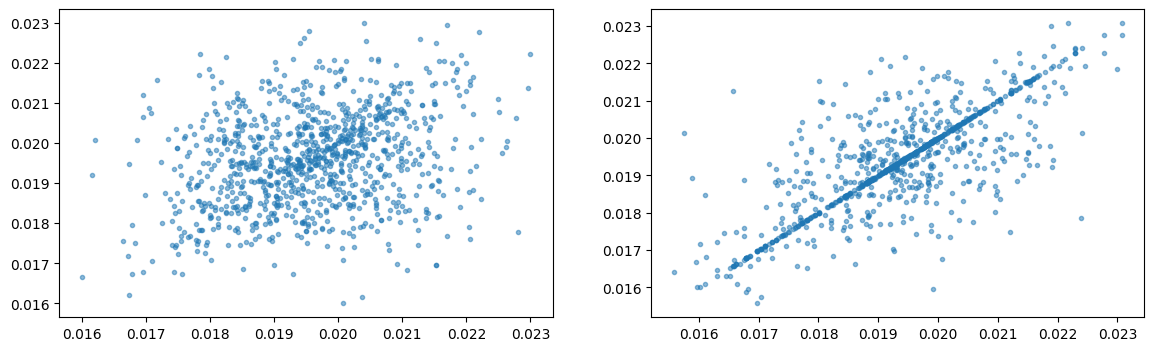

In [39]:
#autocorrelations
import numpy as np;
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0,
                                            draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0,
                                                           draw=slice(1, max_mcmc_samples-1)).values;
ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain",
      np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1],
      "")
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0,
                                                               max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0,
                                                          draw=slice(1, max_mcmc_samples-1)).values;
ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain",
      np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1],
      "")
#we can see HMC has much less correlation than the MH step method

In [40]:
#MCMC: effective sample size, showing HMC because it is clearly the more reliable method
import arviz as az;
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,31.68,0.3,31.10,32.21,0.01,0.01,1302.35,1203.71,1.0
phi,0.02,0.0,0.02,0.02,0.00,0.00,1019.32,1104.11,1.0


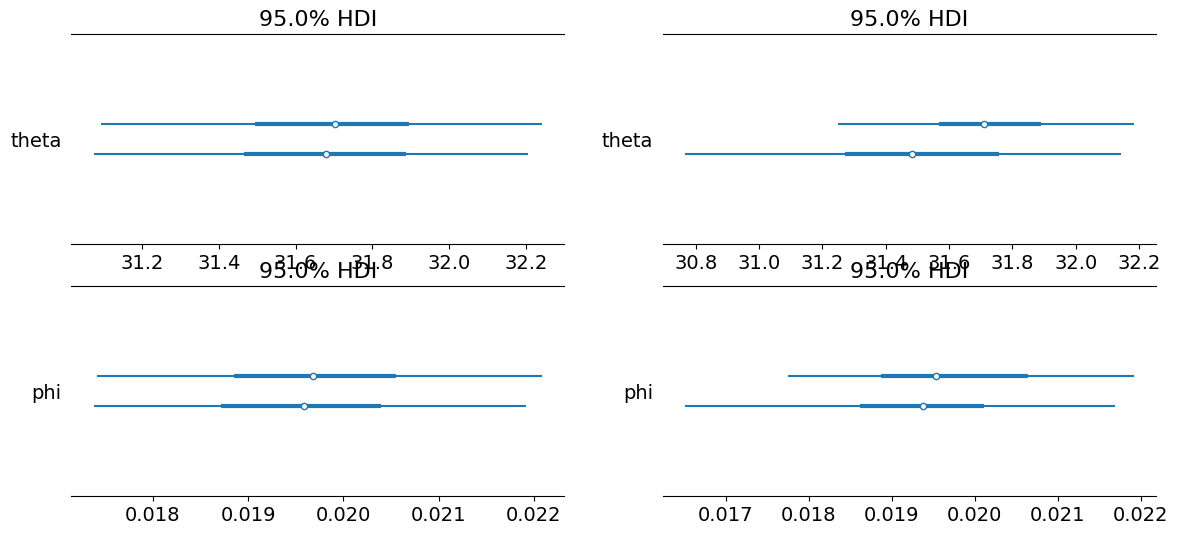

In [41]:
#Credibile intervals
import arviz as az;
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(2,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0,0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1,0]);
az.plot_forest(idata_MH, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0,1]);
az.plot_forest(idata_MH, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1,1]);

<function matplotlib.pyplot.show(close=None, block=None)>

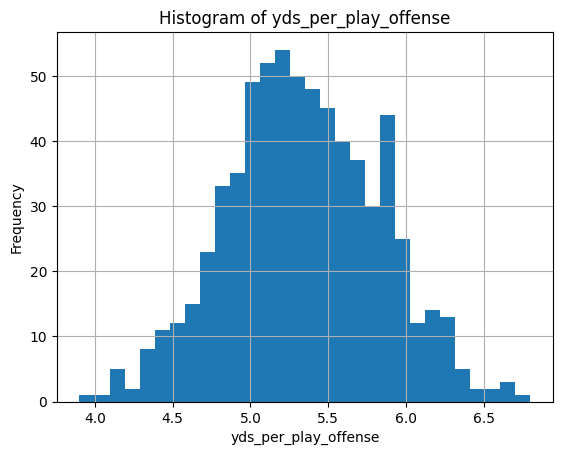

In [76]:
#Question 2,3,4
#hist of score_pct
df.hist('yds_per_play_offense', bins = 30)
plt.xlabel("yds_per_play_offense")
plt.ylabel('Frequency')
plt.title('Histogram of yds_per_play_offense')
plt.show

#pretty heavy tailed with a sharp incline and slow decline,
# means normal-gamma likely wont apply
# could use Chi-squared and beta

In [81]:
#specify the prior parameters
alpha, beta = 2, 5;
nu_0 = 3 #chosen to try and mimic what the histogram would be

np.random.seed(341688)

chi_beta_model = pm.Model()
with chi_beta_model:
  theta = pm.Beta('theta', alpha = alpha, beta = beta)
  phi = pm.ChiSquared('phi', nu = nu_0)
  obs = pm.Normal('liklihood', mu = theta, sigma = 1/phi**0.5,
                  observed = df['yds_per_play_offense'])


In [82]:
#HMC sampling
np.random.seed(341688)
with chi_beta_model:
  idata_HMC = pm.sample()

In [83]:
#M-H sampling
np.random.seed(341688)
with chi_beta_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=True, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))
/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 1.0025, 'phi': 1.0007} | MH Split-Rhats {'theta': 1.1312, 'phi': 1.0052}


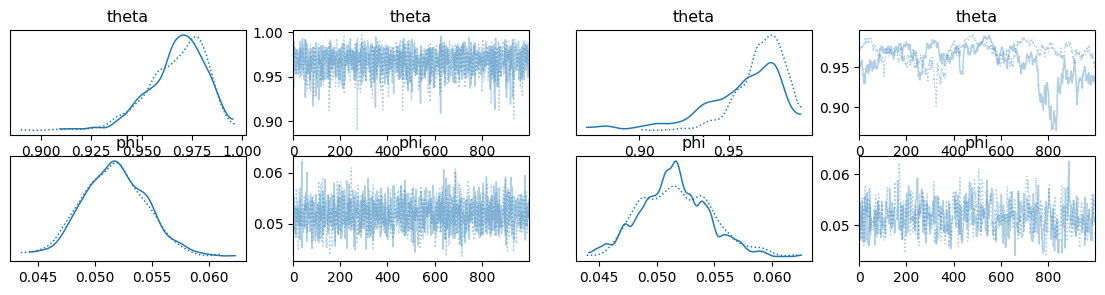

In [84]:
#Convergence diagnostics to make sure algorithm ran correctly and we converged
import arviz as az;
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]);
az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ');
print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})
#both runs look the same  for HMC which is what we want, means we can get
# reliably reproducable results. less so for MH, where the results do not
# look repeatable at all
#also can see that we are converging for HMC, but certainly not close for MH

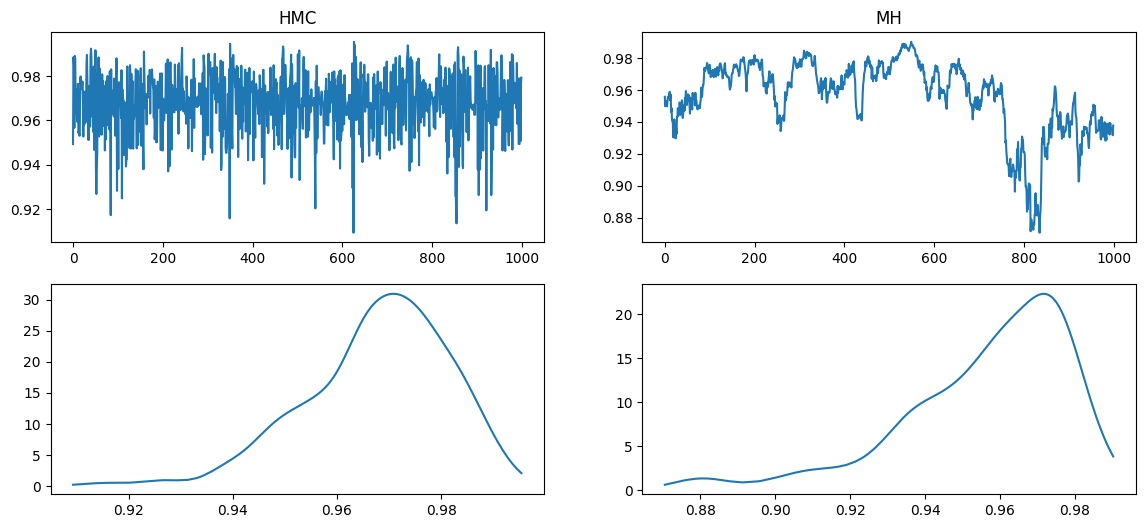

In [85]:
#Closer look at convergence diagnostics
from scipy.stats import gaussian_kde;
import matplotlib.pyplot as plt;
iterations = 100 # Gibbs Samples
theta_gibbs_posterior_mcmc_draws,phi_gibbs_posterior_mcmc_draws = np.zeros(iterations+1),np.zeros(iterations+1)
burn = 20

fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain);
ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain);
ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0,1].set_title("MH");

#again we see much stronger convergence in the HMC method, and a more normal
# pattern in distribbution than in MH

Autocorrelation for HMC (MCMC) chain -0.03536956206168582 
Autocorrelation for MH (MCMC) chain 0.6589196747427402 


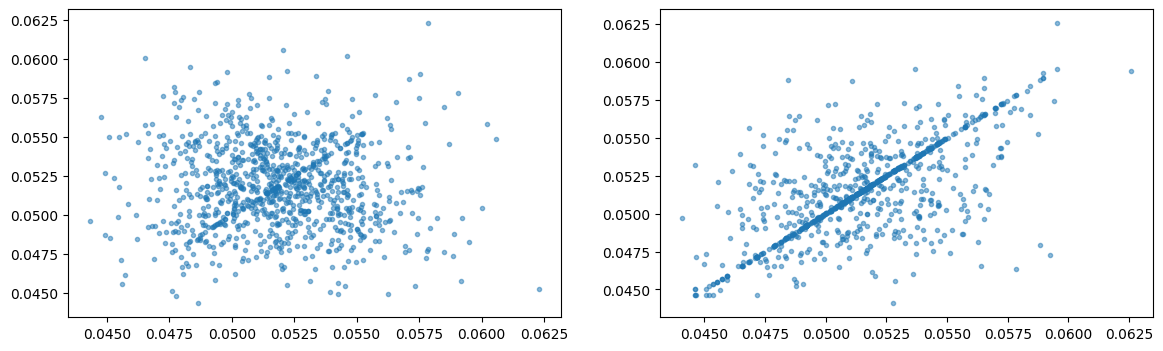

In [86]:
#autocorrelations
import numpy as np;
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0,
                                                                max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0,
                                                           draw=slice(1, max_mcmc_samples-1)).values;
ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,
                                                          mcmc_chain_one_step_ahead)[0,1],
      "")
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0,
                                                               max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0,
                                                          draw=slice(1, max_mcmc_samples-1)).values;
ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,
                                                         mcmc_chain_one_step_ahead)[0,1],
      "")
#we can see HMC has much less correlation than the MH step method,
#in fact we are seeing negative correlation

In [87]:
#MCMC: effective sample size, showing HMC because it is clearly the more reliable method
import arviz as az;
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.97,0.01,0.94,0.99,0.0,0.0,1656.55,1031.43,1.0
phi,0.05,0.00,0.05,0.06,0.0,0.0,1632.60,1128.29,1.0


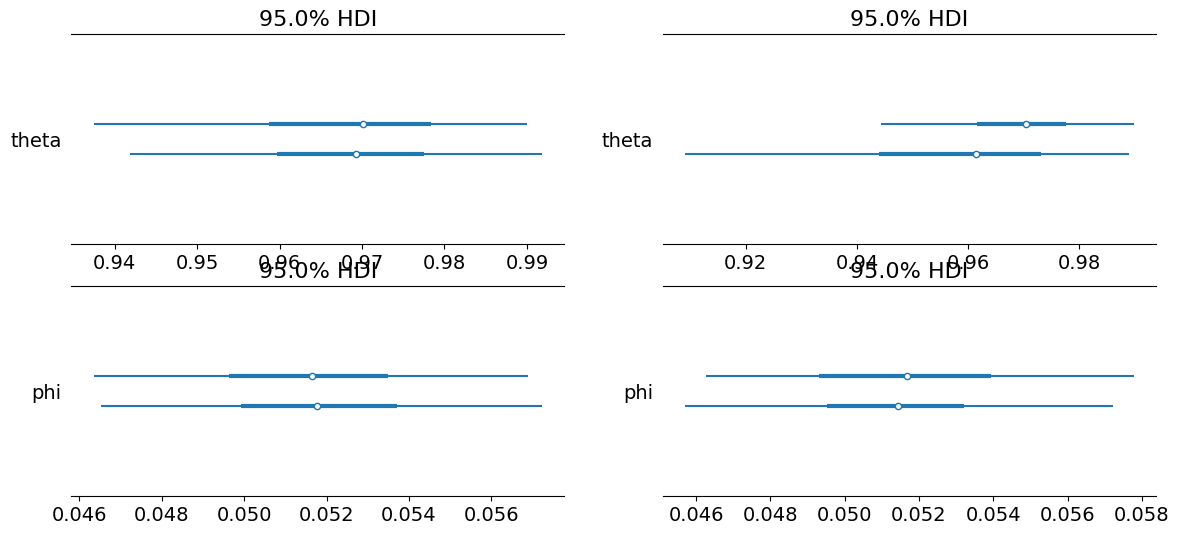

In [88]:
#Credibile intervals
import arviz as az;
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(2,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0,0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1,0]);
az.plot_forest(idata_MH, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0,1]);
az.plot_forest(idata_MH, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1,1]);